# 道路骨架提取

In [4]:
import geopandas as gpd
import momepy
import libpysal
from shapely.ops import voronoi_diagram

# 准备建筑shp

200


C:\Users\Elena\AppData\Local\Temp\ipykernel_4520\88984408.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  buildings.to_file(output_path, encoding='utf-8')
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'building:levels' to 'building_l'
  ogr_write(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'name:zh' to 'name_zh'
  ogr_write(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'name:en' to 'name_en'
  ogr_write(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'addr:city' to 'addr_city'
  ogr_write(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/launder

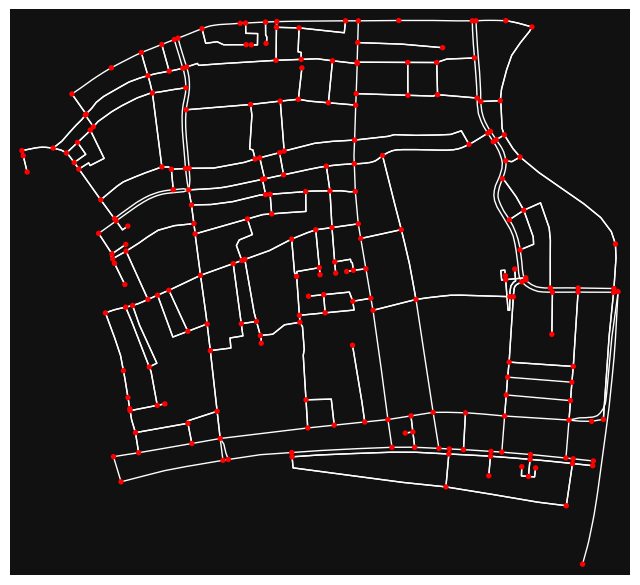

建筑物图层已保存为：buildings.shp


<Axes: >

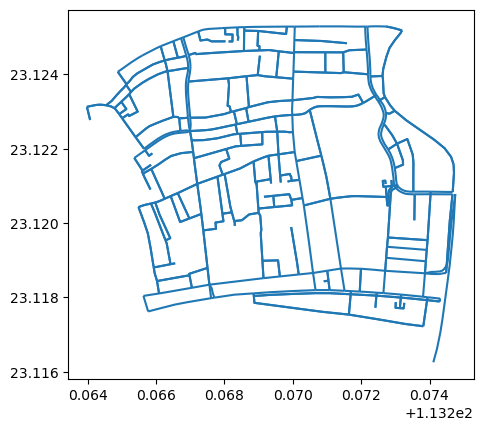

In [11]:
import osmnx as ox
import geopandas as gpd

# Step 1：设置区域名称
place_name = "珠光街道"

# Step 2：下载该区域的建筑图层
buildings = ox.features_from_place(place_name, tags={'building': True})

print(len(buildings))

# Step 3：保留 polygon 类型（建筑轮廓）
buildings = buildings[buildings.geometry.type.isin(['Polygon', 'MultiPolygon'])]

# Step 4：保存为 Shapefile（可在 QGIS 中查看）
output_path = "buildings.shp"

buildings.to_file(output_path, encoding='utf-8')
G = ox.graph_from_place(place_name, network_type='all')
ox.plot_graph(G, node_color='red', edge_color='white')
print(f"建筑物图层已保存为：{output_path}")
nodes,roads= ox.graph_to_gdfs(G, nodes=True, edges=True)
roads.plot()

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\geopandas\array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


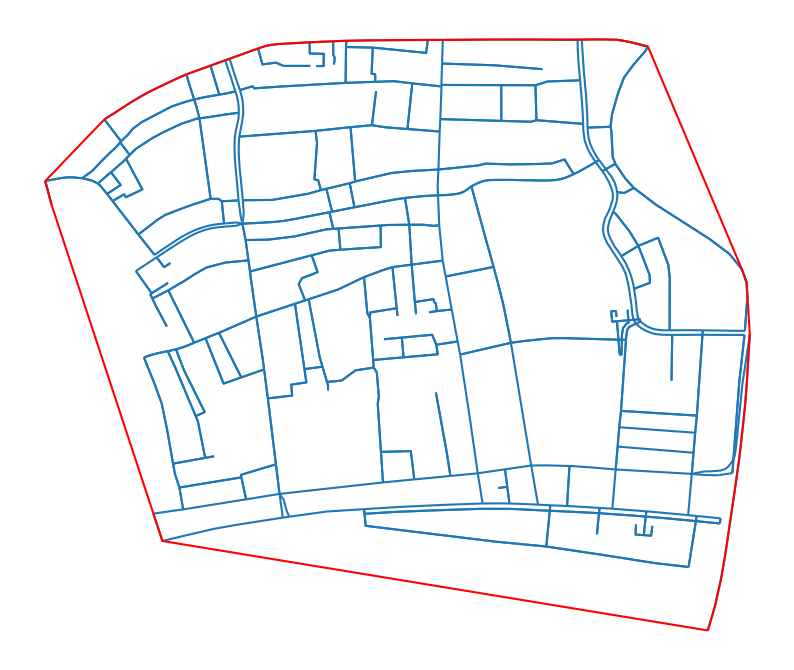

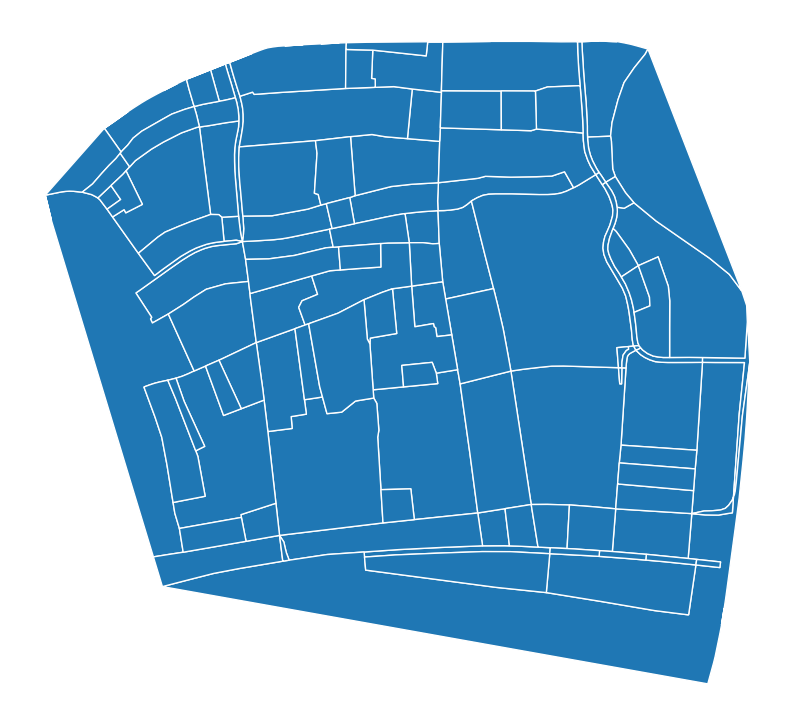

In [12]:
convex_hull = roads.union_all().convex_hull
enclosures = momepy.enclosures(roads, limit=convex_hull)
ax = roads.plot(figsize=(10, 10))
gpd.GeoSeries([convex_hull.boundary]).plot(ax=ax, color="r")
ax.set_axis_off()
enclosures.plot(figsize=(10, 10), edgecolor="w").set_axis_off()

In [22]:
print(enclosures.type)

0      Polygon
1      Polygon
2      Polygon
3      Polygon
4      Polygon
        ...   
110    Polygon
111    Polygon
112    Polygon
113    Polygon
114    Polygon
Length: 115, dtype: object


200


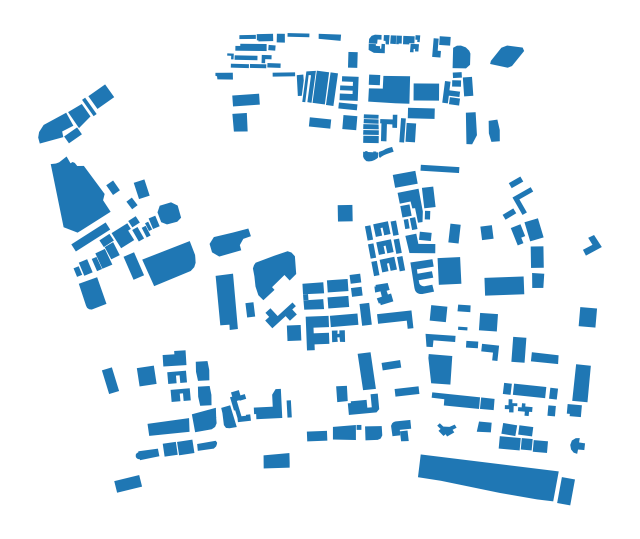

In [13]:
import momepy
import libpysal
from shapely.validation import make_valid
from shapely.geometry import Polygon, LineString
from shapely.errors import TopologicalError

# 建筑图层
buildings = gpd.read_file('buildings.shp').to_crs(epsg=32650)
print(len(buildings))
# 只保留 Polygon 或 MultiPolygon 类型

ax = buildings.plot(figsize=(8, 8))
ax.set_axis_off()



200
                                            geometry
0  MULTIPOLYGON (((117434.396 2561388.661, 117425...


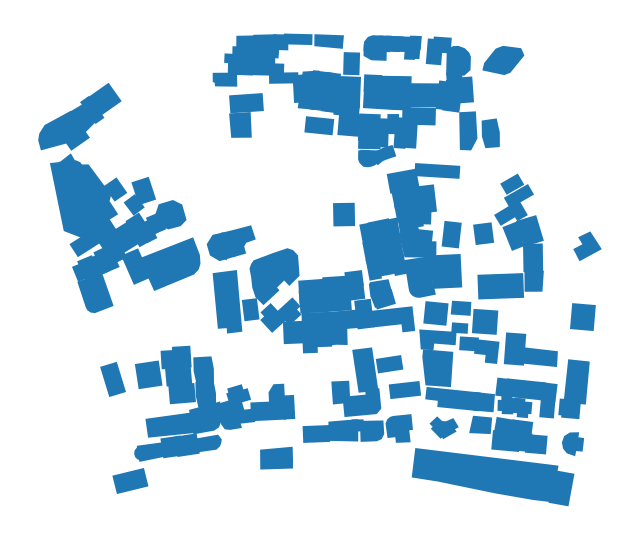

In [14]:
from shapely.ops import unary_union
from shapely.geometry import JOIN_STYLE

buildings_buffered_5m = buildings.copy()
buildings_buffered_5m["geometry"] = buildings_buffered_5m.geometry.buffer(5,join_style=JOIN_STYLE.mitre)
# 第二步：在原来基础上再扩 2 米，控制建筑之间的最小距离
buildings_buffered_7m = buildings_buffered_5m.copy()
buildings_buffered_7m["geometry"] = buildings_buffered_7m.geometry.buffer(2,join_style=JOIN_STYLE.mitre)
print(len(buildings))


# 第三步：将所有相交图形合并为单个 Polygon 或 MultiPolygon
merged_geometry = unary_union(buildings_buffered_7m.geometry)
merged_gdf = gpd.GeoDataFrame(geometry=[merged_geometry], crs=buildings.crs)

ax = buildings_buffered_7m.plot(figsize=(8, 8))
ax.set_axis_off()
print(merged_gdf)

merged_gdf = buildings_buffered_7m

In [104]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, Point, LineString
from scipy.spatial import Delaunay

# 计算三角形外接圆心
def compute_circumcenter(p1, p2, p3):
    A = np.array(p1)
    B = np.array(p2)
    C = np.array(p3)

    mid_ab = (A + B) / 2
    dir_ab = B - A
    perp_ab = np.array([-dir_ab[1], dir_ab[0]])

    mid_bc = (B + C) / 2
    dir_bc = C - B
    perp_bc = np.array([-dir_bc[1], dir_bc[0]])

    try:
        t = np.linalg.solve(np.column_stack((perp_ab, -perp_bc)), mid_bc - mid_ab)
        center = mid_ab + t[0] * perp_ab
        return center
    except np.linalg.LinAlgError:
        return None

# 主函数：输入 enclosure 和 buildings，输出骨架线
def extract_skeleton_from_enclosure(buildings_in, enclosure_geom, spacing=30):
    # 合并建筑为一个几何体
    buildings_union = buildings_in.unary_union
    blank_area = enclosure_geom.difference(buildings_union)

    # 统一为列表格式
    if isinstance(blank_area, Polygon):
        blank_area = [blank_area]
    elif isinstance(blank_area, MultiPolygon):
        blank_area = list(blank_area)

    # Step 1：采样空白区域边界上的点（包括 exterior 和 holes）
    coords = []
    for poly in blank_area:
        # 外边界
        ext_length = poly.exterior.length
        ext_n = int(ext_length // spacing)
        for i in range(ext_n):
            pt = poly.exterior.interpolate(i * spacing)
            coords.append([pt.x, pt.y])
        # 内部孔洞
        for interior in poly.interiors:
            int_length = interior.length
            int_n = int(int_length // spacing)
            for i in range(int_n):
                pt = interior.interpolate(i * spacing)
                coords.append([pt.x, pt.y])

    if len(coords) < 3:
        return gpd.GeoDataFrame(geometry=[], crs=buildings_in.crs)

    # Step 2：构建 Delaunay 三角网
    points = np.array(coords)
    tri = Delaunay(points)

    # Step 3：计算每个三角形的外接圆心
    centers = []
    for simplex in tri.simplices:
        p1, p2, p3 = points[simplex[0]], points[simplex[1]], points[simplex[2]]
        center = compute_circumcenter(p1, p2, p3)
        centers.append(center if center is not None else None)

    # Step 4：连接相邻三角形的圆心 → 构建骨架线
    lines = []
    for i, neighbors in enumerate(tri.neighbors):
        c1 = centers[i]
        if c1 is None:
            continue
        for j, neighbor in enumerate(neighbors):
            if neighbor != -1 and i < neighbor:  # 防止重复
                c2 = centers[neighbor]
                if c2 is not None:
                    line = LineString([c1, c2])
                    # 检查线段是否在空白区域内部
                    mid = line.interpolate(0.5, normalized=True)
                    if any(poly.contains(Point(mid)) for poly in blank_area):
                        lines.append(line)

    # Step 5：转为 GeoDataFrame 输出
    return gpd.GeoDataFrame(geometry=lines, crs=buildings_in.crs)


In [161]:
import networkx as nx
from shapely.geometry import LineString, Point
def clean_skeleton_network(skeleton_gdf, min_length):
    """
    输入为初步骨架线 GeoDataFrame，输出为简化的、干净的“道路骨架网络”
    """
    import networkx as nx
    from shapely.geometry import LineString, MultiLineString

    G = nx.Graph()

    for geom in skeleton_gdf.geometry:
        # 兼容 MultiLineString
        if isinstance(geom, LineString):
            lines = [geom]
        elif isinstance(geom, MultiLineString):
            lines = list(geom.geoms)
        else:
            continue

        for line in lines:
            if line.length < min_length:
                continue
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                p1 = tuple(np.round(coords[i], 3))
                p2 = tuple(np.round(coords[i+1], 3))
                G.add_edge(p1, p2, geometry=LineString([p1, p2]))

    # 只保留最大连通子图
    if nx.number_connected_components(G) == 0:
        return gpd.GeoDataFrame(geometry=[], crs=skeleton_gdf.crs)

    largest_cc = max(nx.connected_components(G), key=len)
    G_sub = G.subgraph(largest_cc).copy()

    # 移除挂链节点（度为1）
    dangling = [n for n in G_sub.nodes if G_sub.degree[n] == 1]
    G_sub.remove_nodes_from(dangling)

    # 提取简化后的边
    cleaned_lines = [data["geometry"] for u, v, data in G_sub.edges(data=True)]

    return gpd.GeoDataFrame(geometry=cleaned_lines, crs=skeleton_gdf.crs)

In [162]:
import networkx as nx
from shapely.geometry import LineString
import numpy as np

def angle_between(p1, p2, p3):
    """计算 ∠p2 的夹角（度数）"""
    a = np.array(p1)
    b = np.array(p2)
    c = np.array(p3)
    v1 = a - b
    v2 = c - b
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    return np.degrees(np.arccos(cos_theta))

def merge_zigzag_segments(skeleton_gdf, angle_threshold):
    """
    将由短线段组成的 zigzag 骨架线合并成方向稳定的长直线
    """
    G = nx.Graph()
    for line in skeleton_gdf.geometry:
        coords = list(line.coords)
        for i in range(len(coords) - 1):
            p1 = tuple(np.round(coords[i], 3))
            p2 = tuple(np.round(coords[i+1], 3))
            G.add_edge(p1, p2)

    merged_lines = []

    for component in nx.connected_components(G):
        subG = G.subgraph(component)
        deg = dict(subG.degree())
        endpoints = [n for n in subG.nodes if deg[n] == 1]

        if len(endpoints) < 2:
            continue

        try:
            path = nx.shortest_path(subG, source=endpoints[0], target=endpoints[1])
        except:
            continue

        # 分段拟合：当角度变化过大就断开
        segment = [path[0], path[1]]
        for i in range(2, len(path)):
            angle = angle_between(path[i-2], path[i-1], path[i])
            if angle < (180 - angle_threshold):  # 弯折太大
                if len(segment) >= 2:
                    merged_lines.append(LineString(segment))
                segment = [path[i-1], path[i]]
            else:
                segment.append(path[i])

        if len(segment) >= 2:
            merged_lines.append(LineString(segment))

    return gpd.GeoDataFrame(geometry=merged_lines, crs=skeleton_gdf.crs)


C:\Users\Elena\AppData\Local\Temp\ipykernel_4520\2082601246.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buildings_union = buildings_in.unary_union
C:\Users\Elena\AppData\Local\Temp\ipykernel_4520\2082601246.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buildings_union = buildings_in.unary_union
C:\Users\Elena\AppData\Local\Temp\ipykernel_4520\2082601246.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buildings_union = buildings_in.unary_union
C:\Users\Elena\AppData\Local\Temp\ipykernel_4520\2082601246.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buildings_union = buildings_in.unary_union
C:\Users\Elena\AppData\Local\Temp\ipykernel_4520\2082601246.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all

<Axes: >

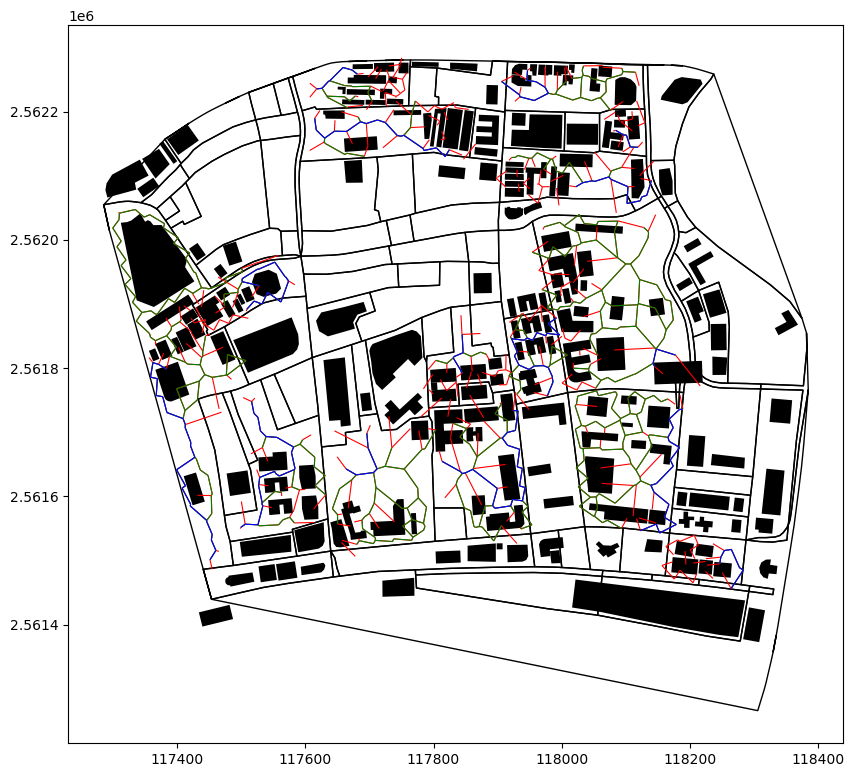

In [170]:
import geopandas as gpd
import pandas as pd
import shapely
from shapely.geometry import Point, Polygon, MultiPolygon
from scipy.spatial import Voronoi
import numpy as np
import matplotlib as plt

# 确保是投影坐标系（如 UTM）
buildings = buildings.to_crs(epsg=32650)
enclosures = enclosures.to_crs(epsg=32650)

# 添加 ID
buildings["uid"] =buildings.index
enclosures["eID"] = enclosures.index

# 结果列表
all_skeletons_raw = []
all_skeletons_clean = []
all_skeletons= []

# 遍历每个 enclosure
for idx, row in enclosures.iterrows():
    enclosure_geom = row["geometry"]
    inside = buildings[buildings.geometry.centroid.intersects(enclosure_geom)]

    if len(inside) < 5:
        continue

    skel_raw = extract_skeleton_from_enclosure(inside, enclosure_geom)
    skel_clean = clean_skeleton_network(skel_raw,0.5)
    skel_straight = merge_zigzag_segments(skel_clean,15)

    all_skeletons_raw.append(skel_raw)
    all_skeletons_clean.append(skel_clean)
    all_skeletons.append(skel_straight)

# 合并为 GeoDataFrame
skeleton_raw = gpd.GeoDataFrame(pd.concat( all_skeletons_raw, ignore_index=True), crs=buildings.crs)
skeleton_clean= gpd.GeoDataFrame(pd.concat( all_skeletons_clean, ignore_index=True), crs=buildings.crs)
skeleton_total = gpd.GeoDataFrame(pd.concat(all_skeletons, ignore_index=True), crs=buildings.crs)

ax = enclosures.plot(edgecolor="black", facecolor="none", figsize=(10, 10))
buildings.plot(ax=ax, color="black")
skeleton_raw .plot(ax=ax, color="red", linewidth=0.8)
skeleton_clean.plot(ax=ax, color="green", linewidth=0.8)
skeleton_total.plot(ax=ax, color="blue", linewidth=0.8)
# for idx, row in enclosures.iterrows():
#     eID = row["eID"]
#     enclosure_geom = row["geometry"]
#
#     inside = buildings[buildings.geometry.centroid.intersects(enclosure_geom)]
#     print(f"eID {eID} 有 {len(inside)} 个建筑")
#
#     # 可视化这个 enclosure 和其中的建筑
#     ax = gpd.GeoSeries([enclosure_geom]).plot(facecolor='none', edgecolor='red')
#     inside.plot(ax=ax, color='blue')

